In [95]:
import pennylane as qml
import numpy as np
from pennylane.transforms import commutation_dag, compile
import networkx as nx
import matplotlib.pyplot as plt
from functools import partial

In [67]:
# example
[ds] = qml.data.load("ketgpt")

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 999
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

circuit() # output: tensor(0.04148455, requires_grad=True)

array([ 0.01990025-0.01800414j,  0.        +0.j        ,
        0.00255374+0.00622259j, ...,  0.        +0.j        ,
       -0.00123588+0.00200629j,  0.        +0.j        ])

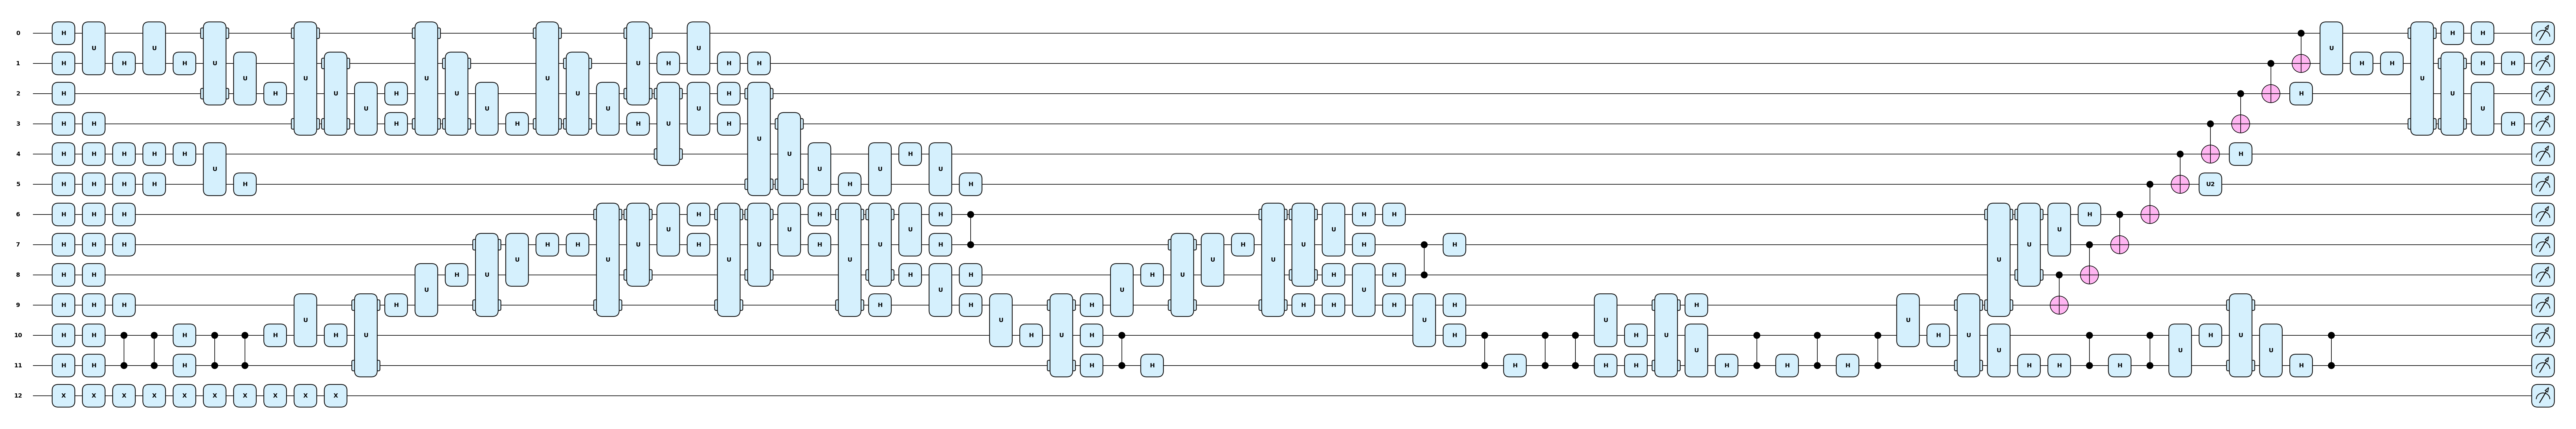

In [68]:
qml.draw_mpl(circuit, style='pennylane')()
plt.show()

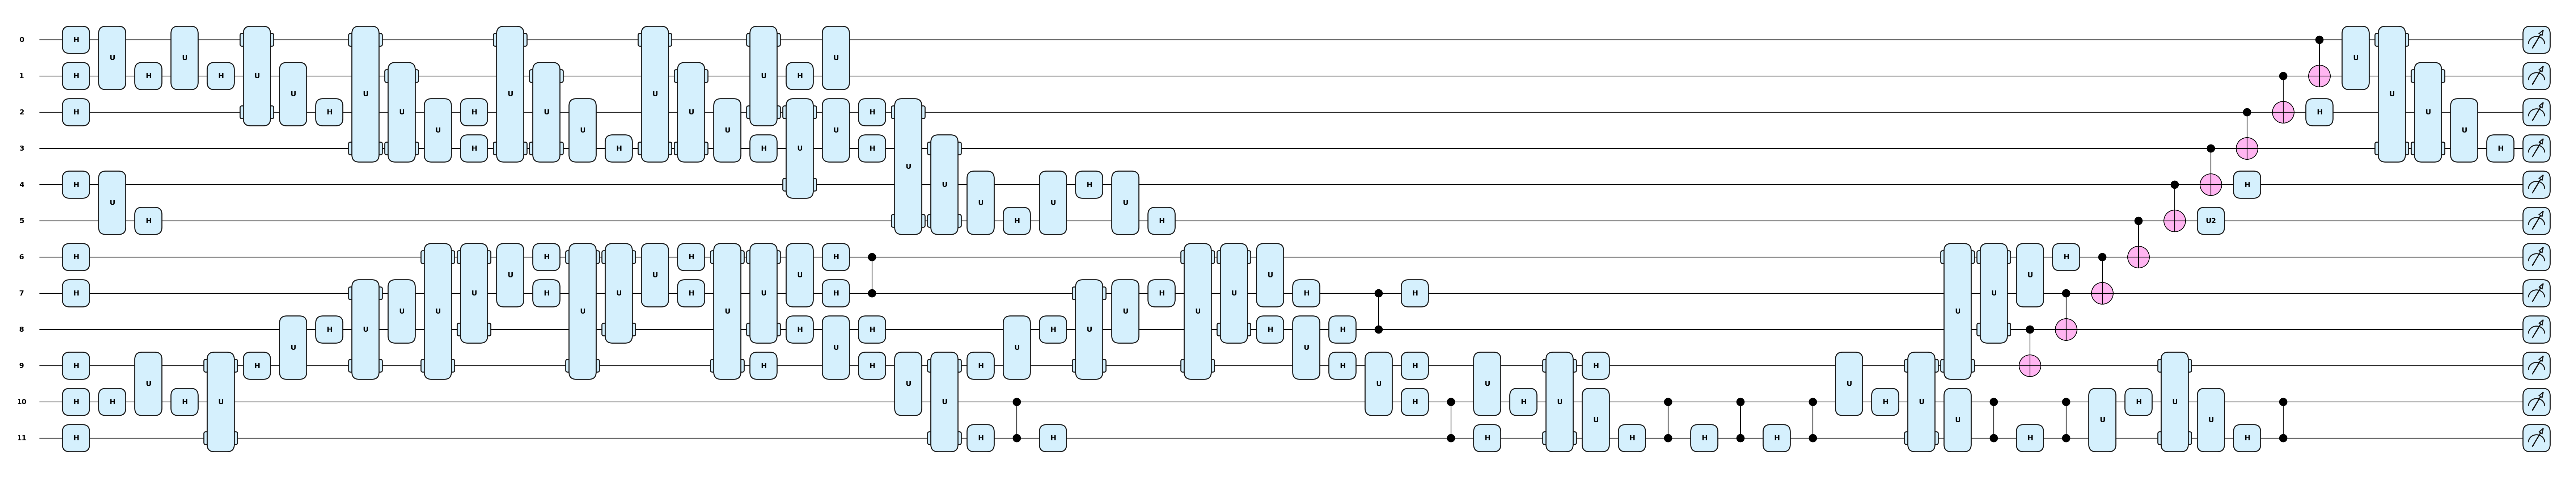

In [103]:
compiled_circuit = compile(circuit)
qml.draw_mpl(compiled_circuit, style='pennylane')()
plt.show()

In [89]:
# any changes?
specs_original = qml.specs(circuit)()

# Manually convert each item to JSON-safe types
clean_specs = {}

for key, value in specs_original.items():
    if key == "resources":
        # Unpack the nested Resources object
        resources_clean = {}
        for res_key, res_val in value.__dict__.items():
            if isinstance(res_val, dict):
                resources_clean[res_key] = {str(k): int(v) for k, v in res_val.items()}
            elif isinstance(res_val, (int, float, bool, str)):
                resources_clean[res_key] = res_val
            else:
                resources_clean[res_key] = str(res_val)
        clean_specs[key] = resources_clean
    elif isinstance(value, np.ndarray):
        clean_specs[key] = value.tolist()
    elif isinstance(value, dict):
        clean_specs[key] = {str(k): int(v) for k, v in value.items()}
    elif isinstance(value, (list, tuple)):
        clean_specs[key] = [str(v) if not isinstance(v, (int, float, bool)) else v for v in value]
    elif isinstance(value, (int, float, bool, str)):
        clean_specs[key] = value
    else:
        clean_specs[key] = str(value)

# Print as JSON
print(json.dumps(clean_specs, indent=2))

{
  "resources": {
    "num_wires": 13,
    "num_gates": 205,
    "gate_types": {
      "Hadamard": 105,
      "CZ": 16,
      "QubitUnitary": 64,
      "PauliX": 10,
      "CNOT": 9,
      "U2": 1
    },
    "gate_sizes": {
      "1": 116,
      "2": 89
    },
    "depth": 72,
    "shots": "Shots(total=None)"
  },
  "errors": {},
  "num_observables": 1,
  "num_trainable_params": 0,
  "num_device_wires": 13,
  "num_tape_wires": 13,
  "device_name": "default.qubit",
  "level": "gradient",
  "gradient_options": {},
  "interface": "auto",
  "diff_method": "best",
  "gradient_fn": "backprop"
}


In [90]:
# to a method that takes a circuit (qnode) and arguments for it
def print_specs(qnode, *args, **kwargs):
    """Prints clean, JSON-formatted specs for a PennyLane QNode."""
    specs_raw = qml.specs(qnode)(*args, **kwargs)
    specs_clean = {}

    for key, value in specs_raw.items():
        if key == "resources":
            # Unpack nested Resources object
            resources_clean = {}
            for res_key, res_val in value.__dict__.items():
                if isinstance(res_val, dict):
                    resources_clean[res_key] = {str(k): int(v) for k, v in res_val.items()}
                elif isinstance(res_val, (int, float, bool, str)):
                    resources_clean[res_key] = res_val
                else:
                    resources_clean[res_key] = str(res_val)
            specs_clean[key] = resources_clean
        elif isinstance(value, np.ndarray):
            specs_clean[key] = value.tolist()
        elif isinstance(value, dict):
            specs_clean[key] = {str(k): int(v) for k, v in value.items()}
        elif isinstance(value, (list, tuple)):
            specs_clean[key] = [str(v) if not isinstance(v, (int, float, bool)) else v for v in value]
        elif isinstance(value, (int, float, bool, str)):
            specs_clean[key] = value
        else:
            specs_clean[key] = str(value)

    print(json.dumps(specs_clean, indent=2))

print_specs(circuit)

{
  "resources": {
    "num_wires": 13,
    "num_gates": 205,
    "gate_types": {
      "Hadamard": 105,
      "CZ": 16,
      "QubitUnitary": 64,
      "PauliX": 10,
      "CNOT": 9,
      "U2": 1
    },
    "gate_sizes": {
      "1": 116,
      "2": 89
    },
    "depth": 72,
    "shots": "Shots(total=None)"
  },
  "errors": {},
  "num_observables": 1,
  "num_trainable_params": 0,
  "num_device_wires": 13,
  "num_tape_wires": 13,
  "device_name": "default.qubit",
  "level": "gradient",
  "gradient_options": {},
  "interface": "auto",
  "diff_method": "best",
  "gradient_fn": "backprop"
}


In [91]:
print_specs(compiled_circuit)

{
  "resources": {
    "num_wires": 12,
    "num_gates": 147,
    "gate_types": {
      "Hadamard": 63,
      "QubitUnitary": 64,
      "CZ": 10,
      "CNOT": 9,
      "U2": 1
    },
    "gate_sizes": {
      "1": 64,
      "2": 83
    },
    "depth": 60,
    "shots": "Shots(total=None)"
  },
  "errors": {},
  "num_observables": 1,
  "num_trainable_params": 66,
  "num_device_wires": 12,
  "num_tape_wires": 12,
  "device_name": "default.qubit",
  "level": "gradient",
  "gradient_options": {},
  "interface": "auto",
  "diff_method": "best",
  "gradient_fn": "backprop"
}


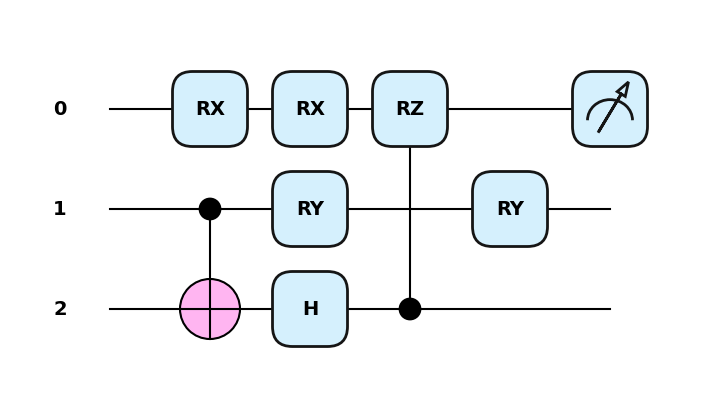

In [51]:
qml.draw_mpl(circuit, style='pennylane')(np.pi / 4, np.pi / 3, np.pi / 2)
plt.show()

In [178]:
@partial(qml.transforms.decompose, gate_set={'CRZ','CZ','SX','X','Identity','RX','RY','RZ','CNOT'})
# @qml.compile
@qml.qnode(qml.device('default.qubit'))
def circuit_comp(): # 0 to 999
    for op in ds.circuits[0]:
        qml.apply(op)
    return qml.state()

circuit_comp() # output: tensor(0.04148455, requires_grad=True)

array([ 0.01800415+0.01990024j,  0.        +0.j        ,
       -0.00622257+0.00255375j, ...,  0.        +0.j        ,
       -0.00200629-0.00123588j,  0.        +0.j        ])

In [179]:
qml.draw_mpl(circuit_comp, style='pennylane')()
plt.show()

In [180]:
dag_fn = commutation_dag(circuit_comp)
dag = dag_fn()

G = dag.graph

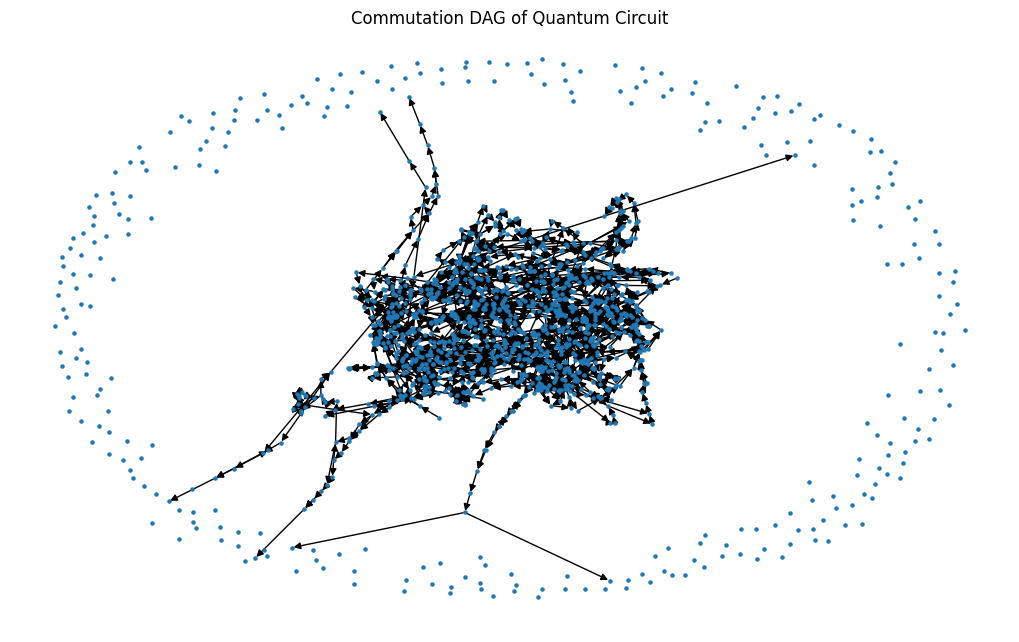

In [181]:
plt.figure(figsize=(10, 6))
# pos = nx.spring_layout(G, seed=42)
# labels = {node: G.nodes[node]["op"].name for node in G.nodes}
nx.draw(G, node_size=5, arrows=True) # pos, 
plt.title("Commutation DAG of Quantum Circuit")
plt.show()